In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

In [44]:
df = pd.read_csv('data_analyzed/0.csv',index_col="time",parse_dates=True)
df = df[4:]
df.head()

,factor_analyzed
time,
1999-11-26,-0.392337
1999-11-29,-0.404363
1999-11-30,-0.741155
1999-12-01,-0.755979
1999-12-02,-0.895709


In [45]:
column = df['factor_analyzed'].count()

print(column)

4549


In [46]:
training_set = df
#training_set = pd.DataFrame(training_set)
training_set.head()

,factor_analyzed
time,
1999-11-26,-0.392337
1999-11-29,-0.404363
1999-11-30,-0.741155
1999-12-01,-0.755979
1999-12-02,-0.895709


In [47]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(4549, 1)

In [48]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(0, column):
    X_train.append(training_set_scaled[i, :])
    y_train.append(training_set_scaled[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4549, 1, 1)

In [49]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

In [50]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
4549/4549 [==============================] - 7s 2ms/step - loss: 0.0045
Epoch 2/10
4549/4549 [==============================] - 1s 220us/step - loss: 2.1808e-04
Epoch 3/10
4549/4549 [==============================] - 1s 222us/step - loss: 1.5044e-04
Epoch 4/10
4549/4549 [==============================] - 1s 217us/step - loss: 1.3829e-04
Epoch 5/10
4549/4549 [==============================] - 1s 221us/step - loss: 1.2593e-04
Epoch 6/10
4549/4549 [==============================] - 1s 219us/step - loss: 1.2406e-04
Epoch 7/10
4549/4549 [==============================] - 1s 218us/step - loss: 1.3674e-04
Epoch 8/10
4549/4549 [==============================] - 1s 219us/step - loss: 1.6117e-04
Epoch 9/10
4549/4549 [==============================] - 1s 222us/step - loss: 1.2128e-04
Epoch 10/10
4549/4549 [==============================] - 1s 219us/step - loss: 1.2053e-04


In [61]:
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = [] # Use this to store the prediction made on each test window
    moving_test_window = []
    moving_test_window.append(training_set_scaled[0, :])       # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    moving_test_window = np.reshape(moving_test_window, (moving_test_window.shape[0], moving_test_window.shape[1], 1))
    
    for i in range(n_future_preds):
        preds_one_step = regressor.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        print(moving_test_window)
    
    return preds_moving

In [62]:
preds_moving = moving_test_window_preds(5)

[[[0.06566379]]]
[[[0.06397221]]]
[[[0.06224497]]]
[[[0.06048243]]]
[[[0.05868507]]]


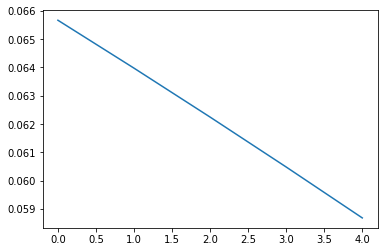

In [58]:
pyplot.plot(preds_moving)

In [54]:
X_test = []
y_test = []
for i in range(column-100, column):
    X_test.append(training_set_scaled[i, :])
    y_test.append(training_set_scaled[i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_predicted = regressor.predict(X_test)

In [55]:
y_predicted = pd.DataFrame(y_predicted)
y_predicted.info
X_test.shape

(100, 1, 1)

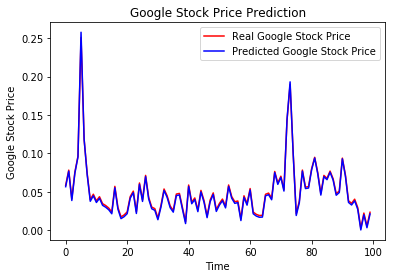

In [56]:
# Visualising the results
plt.plot(training_set_scaled[column-100:, 0], color = 'red', label = 'Real Google Stock Price')
plt.plot(y_predicted[0], color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
# Try add/remove layers
# Change dimensionality of layers
# Split training/test/validation
# Test on specific stocks 
# Combine all stocks into single dataset (60day windows for all stocks)
# Change output dimensionality (predict only open)

In [ ]:
def change_category(now, week_from_now):
    ratio = float(week_from_now)/now
    percentile = (ratio - 1) * 100
    if abs(percentile) >= 5:
        return np.sign(percentile) * 3
    elif abs(percentile) >= 3:
        return np.sign(percentile) * 2
    elif abs(percentile) >= 2:
        return np.sign(percentile)
    else:
        return 0